## Title: Contraceptive Method Choice
2. Sources:
(a) Origin: This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey

(b) Creator: Tjen-Sien Lim (limt@stat.wisc.edu)

(c) Donor: Tjen-Sien Lim (limt@stat.wisc.edu)

(d) Date: June 7, 1997

3. Past Usage:
Lim, T.-S., Loh, W.-Y. & Shih, Y.-S. (1999). A Comparison of Prediction Accuracy, Complexity, and Training Time of Thirty-three Old and New Classification Algorithms. Machine Learning. Forthcoming. (ftp://ftp.stat.wisc.edu/pub/loh/treeprogs/quest1.7/mach1317.pdf or (http://www.stat.wisc.edu/~limt/mach1317.pdf)

4. Relevant Information:
This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either not pregnant or do not know if they were at the time of interview. The problem is to predict the current contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics.

5. Number of Instances: 1473
6. Number of Attributes: 10 (including the class attribute)
7. Attribute Information:
Wife's age (numerical)

Wife's education (categorical) 1=low, 2, 3, 4=high

Husband's education (categorical) 1=low, 2, 3, 4=high

Number of children ever born (numerical)

Wife's religion (binary) 0=Non-Islam, 1=Islam

Wife's now working? (binary) 0=Yes, 1=No

Husband's occupation (categorical) 1, 2, 3, 4

Standard-of-living index (categorical) 1=low, 2, 3, 4=high

Media exposure (binary) 0=Good, 1=Not good

Contraceptive method used (class attribute) 1=No-use ,2=Long-term,3=Short-term

In [129]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
pd.set_option('display.max_columns', 50)
import warnings
warnings.filterwarnings('ignore')
plt.style.use("fivethirtyeight")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools
import pickle

In [3]:
df = pd.read_csv("IndonesiaContraception.csv", header=None, names = ['age_wife', 'education_wife', 'education_husband', 'number_of_children', 'islamic', 'wife_working', 'husband_occupation', 'std_of_living', 'media', 'target'])

In [4]:
df.describe()

,age_wife,education_wife,education_husband,number_of_children,islamic,wife_working,husband_occupation,std_of_living,media,target
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,32.538357,2.958588,3.429735,3.261371,0.850645,0.749491,2.137814,3.133741,0.073999,1.919891
std,8.227245,1.014994,0.816349,2.358549,0.356559,0.433453,0.864857,0.976161,0.261858,0.876376
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000
max,49.000000,4.000000,4.000000,16.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000


In [5]:
df['target'][df['target']==1] = 0
df['target'][df['target']!=0] = 1

In [6]:
df['target'].mean()

0.572980312287848

In [114]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [134]:
def feat_importance_plot(feature_df, rfc_model):
    feature_importances = rfc_model.feature_importances_

    importances = pd.DataFrame({'importance': feature_importances, 'feature': feature_df.columns}, 
                               index=features).sort_values(by='importance', ascending=False)

    sns.set(font_scale=1.50)
    plt.figure(figsize=(15, 5))
    plt.xticks(rotation=90)
    sns.barplot(x='feature', y='importance', data=importances[0:15])

In [151]:
# Create a function that returns the dataframe with accounts and targets for each category
# Use for visualizing low probability events 
def freq_plots(column_name, df, hit_color='blue', miss_color='red', ratio_color='orange', title=' '):
    categories, targets, totals, ratio = [], [], [], []
    bin_min = int(df[column_name].min())
    bin_max = int(df[column_name].max()+1)
    step = 1
    if bin_max-bin_min>100:
        step = ((bin_max-bin_min)//100)+1
        
    for category in range(bin_min, bin_max, step):
        categories.append(category)
        totals.append(df[column_name][(df[column_name]>=category) & 
                                      (df[column_name]<category+step)].count())
        targets.append(df["target"][(df[column_name]>=category) & 
                                          (df[column_name]<category+step)].sum())
        ratio.append(round(targets[-1]/totals[-1], 3))
    count_df = pd.DataFrame(list(zip(categories, totals, targets, ratio)), 
                            columns=[column_name, "total", "target", "ratio"])
    fig, ax = plt.subplots(2, 1, sharex='col', sharey='row')
    ax[0].set_title(title)
    ax[0].bar(categories, np.subtract(totals, targets), width=0.8*step, color=hit_color, label='Misses', bottom=targets)
    ax[0].bar(categories, targets, width=0.8*step, color=miss_color, label='Hits')
    ax[0].set_ylabel("Hits by {}".format(column_name))
    ax[0].set_xlabel(column_name.title())
    ax[0].legend(loc="best")
    ax[1].bar(categories, ratio, width=0.8*step, label='ratio', color=ratio_color)
    ax[1].set_ylabel("Ratio")
    ax[1].set_xlabel(column_name.title())
    ax[1].legend(loc="best")
    return count_df, fig, ax

In [160]:
df['islamic'].sum()

1253

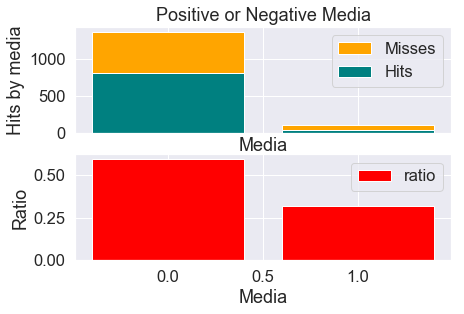

In [157]:
count_df, fig, ax = freq_plots("media", df, hit_color='orange', miss_color='teal', ratio_color='red', title='Positive or Negative Media');
fig.show();

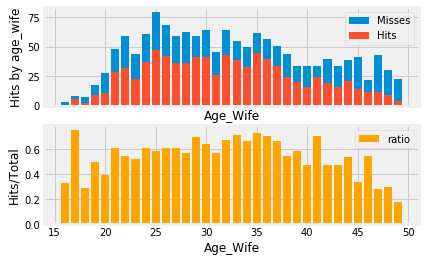

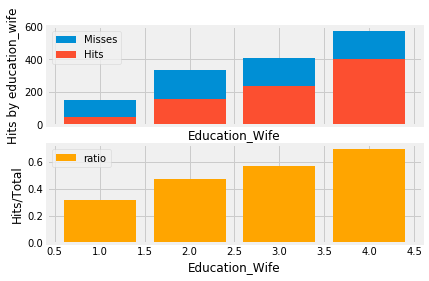

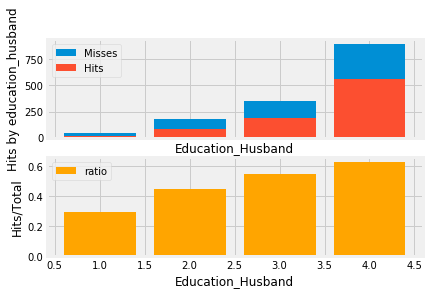

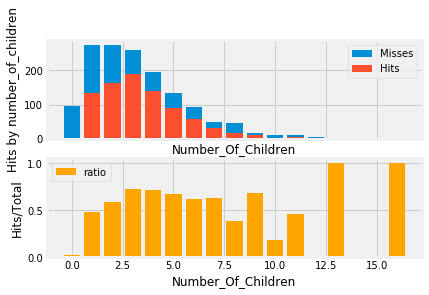

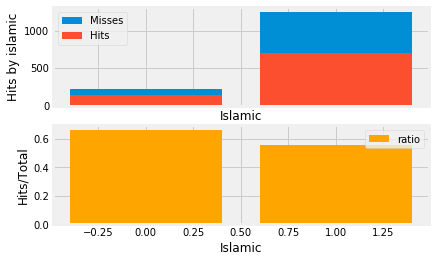

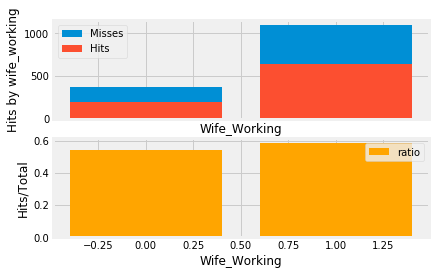

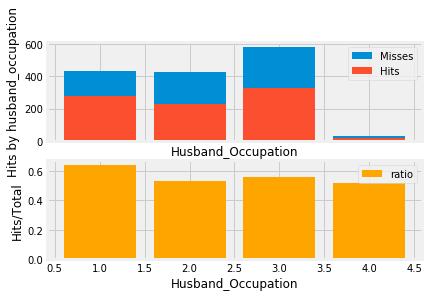

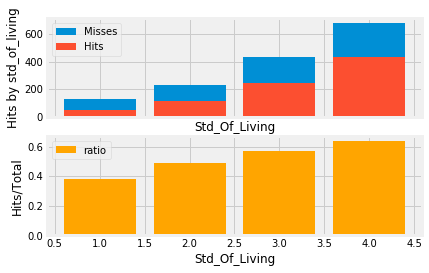

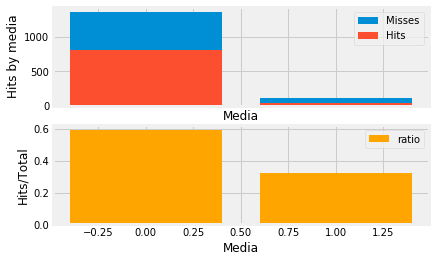

In [9]:
for column_name in df.columns[:-1]:
    freq_plots(column_name, df);

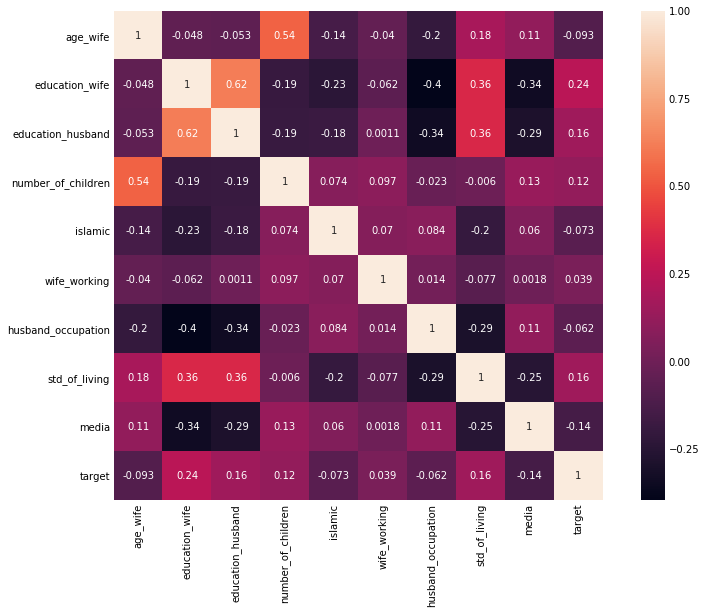

In [10]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True)

In [66]:
feat_df = df.copy()

## Baseline Modeling

In [67]:
# Train Test Split
X = feat_df.drop('target', axis = 1) 

# Create target variable
y = feat_df['target']

# Create a list of the features being used in the X
feature_cols = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [68]:
# Logistic regression

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
y_pred_test = lr_clf.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))


Test Accuracy score:  0.6747967479674797


In [69]:
#Set up logistic regression with cross-validation using liblinear.
#Cs sets the inverse of the regularization strength, which will be optimized
#through cross-validation. Uses the default Stratified K-Folds
#CV generator, with 5 folds.
model_cv = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5)
model_cv.fit(X_train, y_train)
columns = np.arange(X_train.shape[1])[~np.isclose(model_cv.coef_.ravel(), 0)]

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# model_pred = upsampled_dt.predict(X_test)
model_cv_pred = model_cv.predict(X_test)


# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, model_cv_pred))


Test Accuracy score:  0.6287262872628726


In [70]:
#create a container to track the scores
k_scores=[]

#set up a loop to fit the model using a different values of K

k_range = list(range(5, 26, 2))
for k in k_range:
    # instantiate the model (using a different value fopr K)
    knn = KNeighborsClassifier(n_neighbors=k)
    # fit the model with data
    knn.fit(X_train, y_train)
    # make class predictions for the testing set
    y_pred_class = knn.predict(X_test)    
    #fit the model and get the score on a evaluation metric
    accuracy = metrics.accuracy_score(y_pred_class, y_test)
    F1 = metrics.f1_score(y_pred_class, y_test)
    k_scores.append({k : (accuracy, F1)})
    print('k = ' + str(k) + ' Accuracy:' + str(metrics.accuracy_score(y_pred_class, y_test)))
    print()

# Print out the scores to see which one is best. 

k = 5 Accuracy:0.6612466124661247

k = 7 Accuracy:0.6693766937669376

k = 9 Accuracy:0.6720867208672087

k = 11 Accuracy:0.6666666666666666

k = 13 Accuracy:0.6720867208672087

k = 15 Accuracy:0.6775067750677507

k = 17 Accuracy:0.6639566395663956

k = 19 Accuracy:0.6775067750677507

k = 21 Accuracy:0.6612466124661247

k = 23 Accuracy:0.6612466124661247

k = 25 Accuracy:0.6693766937669376



In [71]:
#KNN
knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)
print('Accuracy:' + str(metrics.accuracy_score(y_test, y_pred_class)))

Accuracy:0.6775067750677507


## Best Baseline

In [72]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=4)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#predict the training set
y_pred_train = clf.predict(X_train)

#Predict the response for test dataset
y_pred_test = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))
baseline = accuracy_score(y_test, y_pred_test)

Test Accuracy score:  0.7371273712737128


In [ ]:
# Random Forest
rfc = RandomForestClassifier(random_state = 23, n_estimators=150, max_depth=6, criterion='gini', max_features=0.25)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)

# checking accuracy on the test data
print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred))

In [ ]:
feat_importance(X, )

## Log Variables

In [74]:
feat_df = df.copy()

In [75]:
feat_df["log_number_of_children"] = np.log(feat_df["number_of_children"]+1)
feat_df.drop("number_of_children", axis=1, inplace=True)

In [76]:
# Train Test Split
X = feat_df.drop('target', axis = 1) 

# Create target variable
y = feat_df['target']

# Create a list of the features being used in the 
feature_cols = X.columns
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

Index(['age_wife', 'education_wife', 'education_husband', 'islamic',
       'wife_working', 'husband_occupation', 'std_of_living', 'media',
       'log_number_of_children'],
      dtype='object')


In [77]:
# Scale 
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [78]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=4)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#predict the training set
y_pred_train = clf.predict(X_train)

#Predict the response for test dataset
y_pred_test = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))
print('Improvement over the baseline: ', accuracy_score(y_test, y_pred_test)-baseline)

Test Accuracy score:  0.7371273712737128
Improvement over the baseline:  0.0


Confusion Matrix, without normalization
[[ 88  73]
 [ 24 184]]


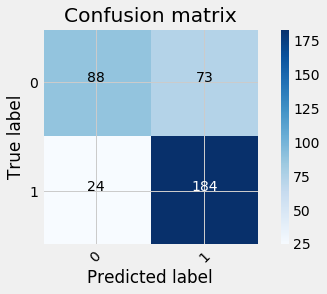

In [79]:
cm = confusion_matrix(y_test, y_pred_test)
classes = ['0', '1']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Polynomial Features

In [35]:
# feat_df = df.copy()

In [80]:
columns = feat_df.drop("target", axis=1).columns

poly = PolynomialFeatures(2)
poly_feat = poly.fit_transform(feat_df.drop("target", axis=1))
print(poly.get_feature_names(columns))

['1', 'age_wife', 'education_wife', 'education_husband', 'islamic', 'wife_working', 'husband_occupation', 'std_of_living', 'media', 'log_number_of_children', 'age_wife^2', 'age_wife education_wife', 'age_wife education_husband', 'age_wife islamic', 'age_wife wife_working', 'age_wife husband_occupation', 'age_wife std_of_living', 'age_wife media', 'age_wife log_number_of_children', 'education_wife^2', 'education_wife education_husband', 'education_wife islamic', 'education_wife wife_working', 'education_wife husband_occupation', 'education_wife std_of_living', 'education_wife media', 'education_wife log_number_of_children', 'education_husband^2', 'education_husband islamic', 'education_husband wife_working', 'education_husband husband_occupation', 'education_husband std_of_living', 'education_husband media', 'education_husband log_number_of_children', 'islamic^2', 'islamic wife_working', 'islamic husband_occupation', 'islamic std_of_living', 'islamic media', 'islamic log_number_of_child

In [81]:
# Train Test Split
X_poly_2 = pd.DataFrame(poly_feat, columns=poly.get_feature_names(columns))

# Create target variable
y = feat_df['target']

# Create a list of the features being used in the 
feature_cols = X_poly_2.columns

X_train, X_test, y_train, y_test = train_test_split(X_poly_2, y, test_size=0.25, random_state=23)

In [82]:
# Scale 
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [86]:
# Logistic regression
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
y_pred_test = lr_clf.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))
print('Improvement over the baseline: ', accuracy_score(y_test, y_pred_test)-baseline)

Test Accuracy score:  0.7235772357723578
Improvement over the baseline:  -0.013550135501354976


In [84]:
# KNN tuning
k_range = list(range(5, 26, 2))
for k in k_range:
    # instantiate the model (using a different value fopr K)
    knn = KNeighborsClassifier(n_neighbors=k)
    # fit the model with data
    knn.fit(X_train, y_train)
    # make class predictions for the testing set
    y_pred_class = knn.predict(X_test)    
    #fit the model and get the score on a evaluation metric
    accuracy = metrics.accuracy_score(y_pred_class, y_test)
    F1 = metrics.f1_score(y_pred_class, y_test)
    k_scores.append({k : (accuracy, F1)})
    print('k = ' + str(k) + ' Accuracy:' + str(metrics.accuracy_score(y_pred_class, y_test)))
    print()

# Print out the scores to see which one is best. 

k = 5 Accuracy:0.6666666666666666

k = 7 Accuracy:0.6747967479674797

k = 9 Accuracy:0.6910569105691057

k = 11 Accuracy:0.6883468834688347

k = 13 Accuracy:0.6883468834688347

k = 15 Accuracy:0.6991869918699187

k = 17 Accuracy:0.6910569105691057

k = 19 Accuracy:0.6991869918699187

k = 21 Accuracy:0.6802168021680217

k = 23 Accuracy:0.6883468834688347

k = 25 Accuracy:0.6639566395663956



In [85]:
#KNN
knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)
print('Accuracy:' + str(metrics.accuracy_score(y_test, y_pred_class)))


Accuracy:0.6991869918699187


In [42]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#predict the training set
y_pred_train = clf.predict(X_train)

#Predict the response for test dataset
y_pred_test = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))


Test Accuracy score:  0.6747967479674797


## Dummy occupation_husband

In [105]:
feat_df = df.copy()

In [106]:
feat_df["log_number_of_children"] = np.log(feat_df["number_of_children"]+1)
feat_df.drop("number_of_children", axis=1, inplace=True)

In [107]:
occ_dummy = pd.get_dummies(feat_df["husband_occupation"], prefix="occ", drop_first=True)
feat_df = pd.concat([feat_df, occ_dummy], axis=1)

feat_df.drop(["husband_occupation"], axis=1, inplace=True)
feat_df.describe()

,age_wife,education_wife,education_husband,islamic,wife_working,std_of_living,media,target,log_number_of_children,occ_2,occ_3,occ_4
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,32.538357,2.958588,3.429735,0.850645,0.749491,3.133741,0.073999,0.572980,1.293708,0.288527,0.397149,0.018330
std,8.227245,1.014994,0.816349,0.356559,0.433453,0.976161,0.261858,0.494813,0.578872,0.453231,0.489473,0.134187
min,16.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,2.000000,3.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000
50%,32.000000,3.000000,4.000000,1.000000,1.000000,3.000000,0.000000,1.000000,1.386294,0.000000,0.000000,0.000000
75%,39.000000,4.000000,4.000000,1.000000,1.000000,4.000000,0.000000,1.000000,1.609438,1.000000,1.000000,0.000000
max,49.000000,4.000000,4.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.833213,1.000000,1.000000,1.000000


In [125]:
columns = feat_df.drop("target", axis=1).columns

poly = PolynomialFeatures(2)
poly_feat = poly.fit_transform(feat_df.drop("target", axis=1))
features = poly.get_feature_names(columns)
print(features)

['1', 'age_wife', 'education_wife', 'education_husband', 'islamic', 'wife_working', 'std_of_living', 'media', 'log_number_of_children', 'occ_2', 'occ_3', 'occ_4', 'age_wife^2', 'age_wife education_wife', 'age_wife education_husband', 'age_wife islamic', 'age_wife wife_working', 'age_wife std_of_living', 'age_wife media', 'age_wife log_number_of_children', 'age_wife occ_2', 'age_wife occ_3', 'age_wife occ_4', 'education_wife^2', 'education_wife education_husband', 'education_wife islamic', 'education_wife wife_working', 'education_wife std_of_living', 'education_wife media', 'education_wife log_number_of_children', 'education_wife occ_2', 'education_wife occ_3', 'education_wife occ_4', 'education_husband^2', 'education_husband islamic', 'education_husband wife_working', 'education_husband std_of_living', 'education_husband media', 'education_husband log_number_of_children', 'education_husband occ_2', 'education_husband occ_3', 'education_husband occ_4', 'islamic^2', 'islamic wife_workin

In [100]:
# Train Test Split
X_poly_2 = pd.DataFrame(poly_feat, columns=poly.get_feature_names(columns))

# Create target variable
y = feat_df['target']

# Create a list of the features being used in the 
feature_cols = X_poly_2.columns

X_train, X_test, y_train, y_test = train_test_split(X_poly_2, y, test_size=0.25, random_state=23)

In [101]:
# Scale 
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [102]:
# Logistic regression
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
y_pred_test = lr_clf.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))

Test Accuracy score:  0.7046070460704607
Improvement over the baseline:  -0.0325203252032521


In [104]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#predict the training set
y_pred_train = clf.predict(X_train)

#Predict the response for test dataset
y_pred_test = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))
print('Improvement over the baseline: ', accuracy_score(y_test, y_pred_test)-baseline)

Test Accuracy score:  0.7317073170731707
Improvement over the baseline:  -0.005420054200542035


## More features?

In [72]:
# feat_df = df.copy()

In [73]:
# feat_df["log_number_of_children"] = np.log(feat_df["number_of_children"]+1)
# feat_df.drop("number_of_children", axis=1, inplace=True)

## Random Forest

In [168]:
feat_df = df.copy()

In [169]:
feat_df["log_number_of_children"] = np.log(feat_df["number_of_children"]+1)
feat_df.drop("number_of_children", axis=1, inplace=True)

In [171]:
# Train Test Split
X = feat_df.drop("target", axis=1)

# Create target variable
y = feat_df['target']

# Create a list of the features being used in the 
feature_cols = X_poly_2.columns

X_train, X_test, y_train, y_test = train_test_split(X_poly_2, y, test_size=0.25, random_state=23)

In [172]:
# Scale 
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [173]:
# Random Forest
rfc = RandomForestClassifier(random_state = 23, n_estimators=150, max_depth=6, criterion='gini', max_features=0.25)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)

# checking accuracy on the test data
print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred))

Test Accuracy score:  0.7452574525745257


In [174]:
# Grid Search with cross-validation
#create a dictionary of all the parameters you want to tune
param_grid = { 
    'n_estimators': [100, 150, 200, 300],
    'max_depth': [5,6,7,8],
    'max_features': [0.01, 0.10, 0.15, 0.25, 0.30, 0.40],
    'min_samples_split': [2,5,10,20]
}

In [175]:
CV_rfc = GridSearchCV(rfc, param_grid, cv=5, n_jobs=3)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'max_depth': 5, 'max_features': 0.1, 'min_samples_split': 20, 'n_estimators': 100}
0.7182971014492754


## Final Model

In [176]:
CV_rfc_pred = CV_rfc.best_estimator_.predict(X_test)
# checking accuracy on the test data
print('Test Accuracy score: ', accuracy_score(y_test, CV_rfc_pred))

Test Accuracy score:  0.7317073170731707


In [179]:
# Random Forest after Grids
# rfc = RandomForestClassifier(random_state = 23, n_estimators=100, max_depth=5, criterion='gini', max_features=0.10)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)

# checking accuracy on the test data
print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred))

Test Accuracy score:  0.7452574525745257


Confusion Matrix, without normalization
[[ 90  71]
 [ 23 185]]


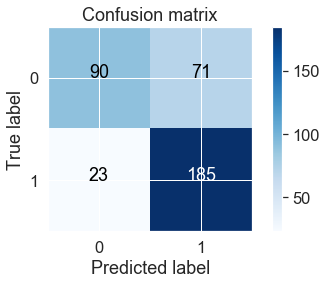

In [180]:
cm = confusion_matrix(y_test, rfc_pred)
classes = ['0', '1']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

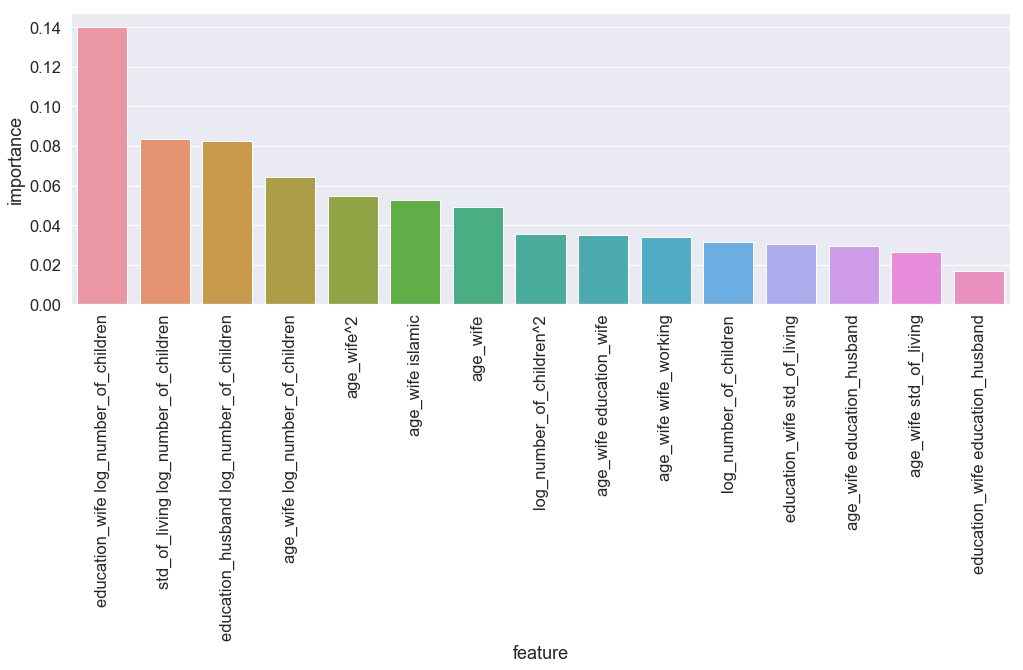

In [135]:
feat_importance_plot(X_poly_2, rfc)

In [177]:
# Saving: Pickling the model
with open('model.pickle', 'wb') as f:
    pickle.dump(rfc, f, pickle.HIGHEST_PROTOCOL)

In [178]:
# Loading Pickle
with open('model.pickle', 'rb') as file:
    rfc = pickle.load(file)